In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Flatten,concatenate,Layer, Dense, Activation,ZeroPadding2D
from tensorflow.keras.layers import MaxPooling2D,Dropout,BatchNormalization,Reshape,UpSampling2D
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG19

In [2]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy.interpolate import interp1d

In [3]:
from scipy.signal import cwt,ricker
from sklearn.preprocessing import StandardScaler
import time

In [4]:
import sys

In [5]:
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = time.clock()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch,time.clock() - self.timetaken))
    def on_train_end(self,logs = {}):
        print('total training time: ',np.sum(self.times))

Which fold to run options: 1-6. Also initializes the ransom seed

In [6]:
h  = 1 #int(sys.argv[1])
rand_sd  = 1117 #int(sys.argv[2])

In [7]:
random.seed(rand_sd)

## Baseline
Generate random topology and create a classifier 

In [8]:
def classify_dense(topology,size3D,N):
    input_layer = keras.Input(shape=(N,size3D))
    x = Flatten()(input_layer)
    for layer in topology['layers']:
        x = Dense(layer['output_shape'], activation=layer['activation'])(x)
    classify_out = Dense(2, activation='softmax')(x)
    classifier = keras.Model(input_layer, classify_out, name="shanon")
    return classifier

In [9]:
# We transform to the data to the frequency domain using
# a Continuous wavelet transform of width 30
numChan = 1
size3D = 30*numChan
N = 500
num_layers = 5

In [10]:
topology = {}
layer_shape = 32*random.randint(5, 40)
topology['layers'] = []
topology['lstm_layers'] = []
for ii in range(num_layers):
    layer = {}
    layer['output_shape'] = layer_shape
    layer_shape = int(layer_shape / 2)
    layer['activation'] = 'relu'
    topology['layers'].append(layer)
layer_shape = 32*random.randint(5, 40)

## Load the data
Exclude one subject for validationa nd one for testing

In [11]:
exclude_subj = 2*h-1
val_subj = 2*h

In [12]:
x = []
y = []
for ii in range(1,12+1):
    if ii == exclude_subj:
        ii = 12
        x1 = np.load('./Experiment3_data/'+str(ii)+'_N_c.npy')
        y1 = np.zeros((x1.shape[0]))
        x2 = np.load('./Experiment3_data/'+str(ii)+'_F_c.npy')
        y2 = np.ones((x2.shape[0]))
        x_tst = np.concatenate([x1[:,:,numChan-1:numChan],x2[:,:,numChan-1:numChan]],axis=0)
        y_tst = np.concatenate([y1,y2],axis=0)
    if ii == val_subj:
        ii = 12
        x1 = np.load('./Experiment3_data/'+str(ii)+'_N_c.npy')
        y1 = np.zeros((x1.shape[0]))
        x2 = np.load('./Experiment3_data/'+str(ii)+'_F_c.npy')
        y2 = np.ones((x2.shape[0]))
        x_val = np.concatenate([x1[:,:,numChan-1:numChan],x2[:,:,numChan-1:numChan]],axis=0)
        y_val = np.concatenate([y1,y2],axis=0)
    x1 = np.load('./Experiment3_data/'+str(ii)+'_N_c.npy')
    y1 = np.zeros((x1.shape[0]))
    x2 = np.load('./Experiment3_data/'+str(ii)+'_F_c.npy')
    y2 = np.ones((x2.shape[0]))
    x.append(x1[:,:,numChan-1:numChan])
    x.append(x2[:,:,numChan-1:numChan])
    y.append(y1)
    y.append(y2)

In [13]:
x_trn = np.concatenate(x,axis=0)
y_trn = np.concatenate(y,axis=0)

In [14]:
y_trn_1h = to_categorical(y_trn, num_classes=2)
y_tst_1h = to_categorical(y_tst, num_classes=2)
y_val_1h = to_categorical(y_val, num_classes=2)

In [15]:
x_trn2  = np.moveaxis(x_trn,0,-1)
x_tst2  = np.moveaxis(x_tst,0,-1)
x_val2  = np.moveaxis(x_val,0,-1)

In [16]:
# to generate limited data plot
p = np.random.permutation(len(y_trn_1h))

Z-scored and transform to a np array of T x Ch x Epochs

In [17]:
scld_x_trn = np.zeros(x_trn2.shape)
for ii in range(x_trn2.shape[1]):
    scaler = StandardScaler()
    scld_x_trn[:,ii,:] = scaler.fit_transform(x_trn2[:,ii,:])
scld_x_tst = np.zeros(x_tst2.shape)
for ii in range(x_tst2.shape[1]):
    scaler = StandardScaler()
    scld_x_tst[:,ii,:] = scaler.fit_transform(x_tst2[:,ii,:])
scld_x_val = np.zeros(x_val2.shape)
for ii in range(x_val2.shape[1]):
    scaler = StandardScaler()
    scld_x_val[:,ii,:] = scaler.fit_transform(x_val2[:,ii,:])

Apply a Continuous wavelet transform of width 30

In [18]:
widths = np.arange(1, 31)
scld_x_trn_cwt = np.zeros((scld_x_trn.shape[0],scld_x_trn.shape[1]*30,scld_x_trn.shape[2]))
for ep in range(scld_x_trn.shape[2]):
    cwtmatr_lst = []
    for ch in range(scld_x_trn.shape[1]):
        cwtmatr = cwt(scld_x_trn[:,ch,ep], ricker, widths)
        cwtmatr = np.moveaxis(cwtmatr,1,0)
        cwtmatr_lst.append(cwtmatr)
    scld_x_trn_cwt[:,:,ep] = np.concatenate(cwtmatr_lst,axis=1)

In [19]:
widths = np.arange(1, 31)
scld_x_tst_cwt = np.zeros((scld_x_tst.shape[0],scld_x_tst.shape[1]*30,scld_x_tst.shape[2]))
for ep in range(scld_x_tst.shape[2]):
    cwtmatr_lst = []
    for ch in range(scld_x_tst.shape[1]):
        cwtmatr = cwt(scld_x_tst[:,ch,ep], ricker, widths)
        cwtmatr = np.moveaxis(cwtmatr,1,0)
        cwtmatr_lst.append(cwtmatr)
    scld_x_tst_cwt[:,:,ep] = np.concatenate(cwtmatr_lst,axis=1)

In [20]:
widths = np.arange(1, 31)
scld_x_val_cwt = np.zeros((scld_x_val.shape[0],scld_x_val.shape[1]*30,scld_x_val.shape[2]))
for ep in range(scld_x_val.shape[2]):
    cwtmatr_lst = []
    for ch in range(scld_x_val.shape[1]):
        cwtmatr = cwt(scld_x_val[:,ch,ep], ricker, widths)
        cwtmatr = np.moveaxis(cwtmatr,1,0)
        cwtmatr_lst.append(cwtmatr)
    scld_x_val_cwt[:,:,ep] = np.concatenate(cwtmatr_lst,axis=1)

In [21]:
scld_x_trn_cwt_swch = np.moveaxis(scld_x_trn_cwt,-1,0)
scld_x_tst_cwt_swch = np.moveaxis(scld_x_tst_cwt,-1,0)
scld_x_val_cwt_swch = np.moveaxis(scld_x_val_cwt,-1,0)

In [22]:
scld_x_trn_cwt_swch.shape

(7200, 500, 30)

## Running the neural networks
For the VGG, dense, and FIN networks

Useful when you want to run multiple iterations in parallel

In [23]:
def run_dense_once(topology,size3D,N,scld_x_trn_cwt_swch,y_trn_1h,scld_x_val_cwt_swch,y_val_1h,scld_x_tst_cwt_swch,y_tst,pIdx,Epoch_num):
    dense = classify_dense(topology,size3D,N)
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)
    tm = timecallback()
    grad_desc_algorithm = keras.optimizers.SGD()
    dense.compile(optimizer = grad_desc_algorithm,
                       loss = 'categorical_crossentropy') # Loss definitions
    loss_d = dense.fit(scld_x_trn_cwt_swch[pIdx,:,:], y_trn_1h[pIdx,:],   # Fit on the dataset
                validation_data=(scld_x_val_cwt_swch,y_val_1h),
                epochs = Epoch_num,
                batch_size = 100,
                verbose = 0,                      # display options to console
                callbacks=[es,tm],
                shuffle=True)
    y_pred_1h = dense.predict(scld_x_tst_cwt_swch)
    y_pred = np.argmax(y_pred_1h,axis=1)
    return accuracy_score(y_pred,y_tst),loss_d

In [24]:
def run_sh_once(sh_model,size3D,N,scld_x_trn_cwt_swch,
                y_trn_1h,scld_x_val_cwt_swch,y_val_1h,scld_x_tst_cwt_swch,y_tst,pIdx,Epoch_num):
    sh_model1 = keras.models.clone_model(sh_model)
    # Scott, D. 1979. On optimal and data-based histograms. Biometrika, 66:605-610.
    # Three assumptions were made to obtain the Scott's result. 
    # First, the Scott's result is asymptotically true (i.e. it is true for large sample size n). 
    # Second, the scaling exponent -1/3 is true if the density is a smooth function. 
    # Third, the coefficient 3.49 was obtained, assuming the Gauss density function as a reference. 
    binWidth = 3.49/np.cbrt(N)
    sh_inp0 = sh_model1.input[0]
    sh_inp1 = sh_model1.input[1]
    sh_out = sh_model1.layers[-2].output
    sh_model2 = keras.Model([sh_inp0,sh_inp1], sh_out)
    in_ch = Input(batch_shape=(None, 500, 30))
    in_bW = Input(batch_shape=(None, 1, 30))
    out = sh_model2([in_ch,in_bW])
    classify_out = Dense(2, activation='softmax')(out)
    bw_arr = np.ones((scld_x_trn_cwt_swch.shape[0],1,30))*binWidth
    bw_arr_val = np.ones((scld_x_val_cwt_swch.shape[0],1,30))*binWidth
    bw_arr_tst = np.ones((scld_x_tst_cwt_swch.shape[0],1,30))*binWidth
    model2 = keras.Model([in_ch,in_bW], classify_out)
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)
    tm = timecallback()
    grad_desc_algorithm = keras.optimizers.SGD()
    model2.compile(optimizer = grad_desc_algorithm,
                       loss = 'categorical_crossentropy') # Loss definitions
    loss_2 = model2.fit([scld_x_trn_cwt_swch[pIdx,:,:],bw_arr[pIdx,:]], y_trn_1h[pIdx,:],   # Fit on the dataset
                validation_data=([scld_x_val_cwt_swch,bw_arr_tst],y_val_1h),
                epochs = Epoch_num,
                batch_size = 100,
                verbose         = 0,                      # display options to console
                callbacks=[es,tm],
                shuffle=True)
    y_pred_1h = model2.predict([scld_x_tst_cwt_swch,bw_arr_tst])
    y_pred = np.argmax(y_pred_1h,axis=1)
    return accuracy_score(y_pred,y_tst),loss_2

In [25]:
def get_vgg(vgg_data,num_classes):
    vgg_dat = Input(shape=vgg_data.shape[1:])
    vgg = VGG19(
        include_top=False, weights='imagenet',
        input_shape=vgg_data.shape[1:], pooling=None,
        input_tensor=vgg_dat)
    vgg_out = vgg.layers[-1].output
    vgg_out_f = Flatten()(vgg_out)
    classify_vgg = Dense(num_classes, activation='softmax')(vgg_out_f)
    vgg_model2 = keras.Model(vgg_dat, classify_vgg)
    return vgg_model2

In [26]:
# We need to pad the data as VGG expects a unique format
# This is how this is usuallu done: https://ieeexplore.ieee.org/document/8772136
def data2vgg(data):
    vgg_data = []
    for ii in range(data.shape[0]):
        ext_dat = np.pad(data[ii,:,:],[(0,0),(1,1)],mode='symmetric')
        vgg_data.append(np.stack([ext_dat,ext_dat,ext_dat],axis=2))
    vgg_data = np.array(vgg_data)
    return vgg_data

In [27]:
def run_vgg_once(size3D,N,scld_x_trn_cwt_swch,
                y_trn_1h,scld_x_val_cwt_swch,y_val_1h,scld_x_tst_cwt_swch,y_tst,pIdx,Epoch_num):
    vx_trn = data2vgg(scld_x_trn_cwt_swch)
    vx_val = data2vgg(scld_x_val_cwt_swch)
    vx_tst = data2vgg(scld_x_tst_cwt_swch)
    vgg_model2 = get_vgg(vx_trn,2)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)
    tm = timecallback()
    grad_desc_algorithm = keras.optimizers.SGD()
    vgg_model2.compile(optimizer = grad_desc_algorithm,loss = 'categorical_crossentropy') # Loss definitions
    loss_d = vgg_model2.fit(vx_trn, y_trn_1h,   # Fit on the dataset
                validation_data=(vx_val,y_val_1h),
                epochs = Epoch_num,
                batch_size = 100,
                verbose = 1,                      # display options to console
                callbacks=[es,tm],
                shuffle=True)
    y_pred_1h = vgg_model2.predict(vx_tst)
    y_pred = np.argmax(y_pred_1h,axis=1)
    return accuracy_score(y_pred,y_tst),loss_d

# The Experiemnt
load the pretrained entropy network

In [28]:
sh_model = load_model('./trained_models/entropy_dense.h5')

In [29]:
Epoch_num = 5

In [30]:
#r = np.random.RandomState()
#saved_state = r.get_state()
#r.set_state(saved_state)
random.seed(rand_sd)
tf.random.set_seed(rand_sd)

In [31]:
acc_dic = {'dense':[],'fin':[],'vgg':[]}
for pp in range(25,125,25):
    data_per = pp
    pIdx = p[0:int(len(y_trn_1h)*data_per/100)]
    acc_lst_d = []
    acc_lst_f = []
    acc_lst_v = []
    for ii in range(1):
        print('-----------------------')
        print('for dense:')
        acc, loss = run_dense_once(topology,size3D,N,scld_x_trn_cwt_swch,y_trn_1h,scld_x_val_cwt_swch,y_val_1h,scld_x_tst_cwt_swch,y_tst,pIdx,Epoch_num)
        acc_lst_d.append(acc)
        print(acc)
        print('for FIN:')
        acc, loss = run_sh_once(sh_model,size3D,N,scld_x_trn_cwt_swch,y_trn_1h,scld_x_val_cwt_swch,y_val_1h,scld_x_tst_cwt_swch,y_tst,pIdx,Epoch_num)
        acc_lst_f.append(acc)
        print(acc)
        #print('for VGG:')
        #acc, loss = run_vgg_once(size3D,N,scld_x_trn_cwt_swch,y_trn_1h,scld_x_val_cwt_swch,y_val_1h,scld_x_tst_cwt_swch,y_tst,pIdx,Epoch_num)
        #acc_lst_v.append(acc)
        #print(acc)
        #print('###########################')
    acc_dic['dense'].append(acc_lst_d)
    acc_dic['fin'].append(acc_lst_f)
    #acc_dic['v'].append(acc_lst_v)

-----------------------
for dense:
total training time:  71.808346
0.8233333333333334
for FIN:
total training time:  50.11572700000001
0.8433333333333334
-----------------------
for dense:
total training time:  120.51166699999999
0.925
for FIN:
total training time:  81.81787200000005
0.9383333333333334
-----------------------
for dense:
total training time:  169.46603400000004
0.9566666666666667
for FIN:
total training time:  114.75568899999999
0.98
-----------------------
for dense:
total training time:  216.27199500000003
0.9933333333333333
for FIN:
total training time:  146.52781400000003
0.97


In [40]:
dense_res = np.mean(np.array(acc_dic['dense']),axis=1)
fin_res = np.mean(np.array(acc_dic['fin']),axis=1)

In [69]:
x = (fin_res-dense_res)*100
f_cubic = interp1d(range(4), x, kind='quadratic')

In [70]:
#define x as 200 equally spaced values between the min and max of original x 
xnew = np.linspace(0, 3, 100)

Text(0, 0.5, 'difference in accuracy (percent)')

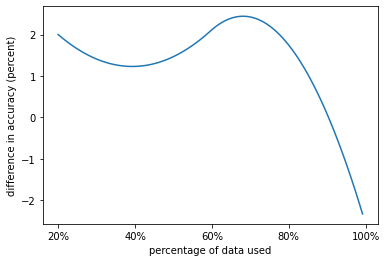

In [74]:
plt.plot(range(100),f_cubic(xnew))
plt.xticks(range(0,125,25), ['20%','40%','60%','80%','100%']) #, rotation='vertical')
plt.xlabel('percentage of data used') 
plt.ylabel('difference in accuracy (percent)') 

In [153]:
'''
res_dict = {'bse_trn_loss':loss_d.history['loss'],
            'bse_val_loss':loss_d.history['val_loss'],
            'fin_trn_loss':loss_2.history['loss'],
            'fin_val_loss':loss_2.history['val_loss'],
            'bse_acc':accuracy_score(y_pred,y_tst),
            'fin_acc':accuracy_score(y2_pred,y_tst),
           }
np.save(str(h)+'_res_file_a.npy', res_dict) 
'''

In [354]:
def reinitialize_model(model):
    weights = []
    initializers = []
    for layer in model.layers:
        if isinstance(layer, (keras.layers.Dense, keras.layers.Conv2D)):
            weights += [layer.kernel, layer.bias]
            initializers += [layer.kernel_initializer, layer.bias_initializer]
        elif isinstance(layer, keras.layers.BatchNormalization):
            weights += [layer.gamma, layer.beta, layer.moving_mean, layer.moving_variance]
            initializers += [layer.gamma_initializer,
                           layer.beta_initializer,
                           layer.moving_mean_initializer,
                           layer.moving_variance_initializer]
    #print(weights)
    for w, init in zip(weights, initializers):
        w.assign(init(w.shape, dtype=w.dtype))

In [355]:
sh_model1 = load_model('./dense_test.h5')
reinitialize_model(sh_model1)

# Exampel of how to use the VGG

In [30]:
vgg = get_vgg(vx,2)

In [31]:
vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 32, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 32, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 32, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 16, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 16, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 16, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 125, 8, 128)       0     